In [1]:
import os 
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import keras 
from keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import shutil

In [2]:
def load_dataset(dataset_path):
    images = []
    labels = []
    for classfolder in os.listdir(dataset_path):
        subclassfolder = os.path.join(dataset_path, classfolder)
        for image_filename in os.listdir(subclassfolder):
            image_path = os.path.join(subclassfolder, image_filename)
            images.append(image_path)
            labels.append(classfolder)
    df = pd.DataFrame({'image': images, 'label': labels})
    return df

In [3]:
PATH_DATASET_ORI = "./PlantVillage/color/"
PATH_DATASET_AUG = "./PlantVillage/augmented/"

In [4]:
data = load_dataset(PATH_DATASET_ORI)
data.head()

,image,label
0,./PlantVillage/color/Apple___Apple_scab\00075a...,Apple___Apple_scab
1,./PlantVillage/color/Apple___Apple_scab\01a663...,Apple___Apple_scab
2,./PlantVillage/color/Apple___Apple_scab\01f3de...,Apple___Apple_scab
3,./PlantVillage/color/Apple___Apple_scab\0208f4...,Apple___Apple_scab
4,./PlantVillage/color/Apple___Apple_scab\023123...,Apple___Apple_scab


In [5]:
dataset_aug = load_dataset(PATH_DATASET_AUG)
dataset_aug.head()

,image,label
0,./PlantVillage/augmented/Apple___Apple_scab\00...,Apple___Apple_scab
1,./PlantVillage/augmented/Apple___Apple_scab\01...,Apple___Apple_scab
2,./PlantVillage/augmented/Apple___Apple_scab\01...,Apple___Apple_scab
3,./PlantVillage/augmented/Apple___Apple_scab\02...,Apple___Apple_scab
4,./PlantVillage/augmented/Apple___Apple_scab\02...,Apple___Apple_scab


In [6]:
X_train, X_temp, y_train, y_temp = train_test_split(dataset_aug['image'], dataset_aug['label'], test_size=0.2, random_state=42,shuffle=True,stratify=dataset_aug['label'])
X_val, X_test, y_val, y_test = train_test_split(X_temp,y_temp, test_size=0.5, random_state=42,shuffle=True,stratify=y_temp)
df_train = pd.DataFrame({'image': X_train, 'label': y_train})
df_test = pd.DataFrame({'image': X_test, 'label': y_test})
df_val = pd.DataFrame({'image': X_val, 'label': y_val})

In [7]:
dist_data = data['label'].value_counts()
dist_data

label
Orange___Haunglongbing_(Citrus_greening)              5507
Tomato___Tomato_Yellow_Leaf_Curl_Virus                5357
Soybean___healthy                                     5090
Peach___Bacterial_spot                                2297
Tomato___Bacterial_spot                               2127
Tomato___Late_blight                                  1909
Squash___Powdery_mildew                               1835
Tomato___Septoria_leaf_spot                           1771
Tomato___Spider_mites Two-spotted_spider_mite         1676
Apple___healthy                                       1645
Tomato___healthy                                      1591
Blueberry___healthy                                   1502
Pepper,_bell___healthy                                1478
Tomato___Target_Spot                                  1404
Grape___Esca_(Black_Measles)                          1383
Corn_(maize)___Common_rust_                           1192
Grape___Black_rot                                 

In [8]:
label_thous = dist_data[dist_data>1000].index
label_thous

Index(['Orange___Haunglongbing_(Citrus_greening)',
       'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Soybean___healthy',
       'Peach___Bacterial_spot', 'Tomato___Bacterial_spot',
       'Tomato___Late_blight', 'Squash___Powdery_mildew',
       'Tomato___Septoria_leaf_spot',
       'Tomato___Spider_mites Two-spotted_spider_mite', 'Apple___healthy',
       'Tomato___healthy', 'Blueberry___healthy', 'Pepper,_bell___healthy',
       'Tomato___Target_Spot', 'Grape___Esca_(Black_Measles)',
       'Corn_(maize)___Common_rust_', 'Grape___Black_rot',
       'Corn_(maize)___healthy', 'Strawberry___Leaf_scorch',
       'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
       'Cherry_(including_sour)___Powdery_mildew'],
      dtype='object', name='label')

In [9]:
def custom_train_generator(dataframe, datagen_aug, datagen_non, target_size, batch_size=32):
    while True:
        img_batch = []
        img_label = []
        
        for index, row in dataframe.iterrows():
            img = load_img(row['image'], target_size=target_size)  # Muat gambar
            img_array = img_to_array(img)  # Konversi ke array
            img_array = np.expand_dims(img_array, axis=0)

            # Augmenting images for labels with 1000 images because we didn't add images with 1000 images before
            if row['label'] in label_thous:
                # print("augmenting")
                for batch in datagen_aug.flow(img_array, batch_size=1): # batch shape (1, 224, 224, 3)
                    aug_img_array = batch[0]                            # Take the first image from the batch
                    break
                # or
                # aug_img_array = next(datagen.flow(img_array, batch_size=1))
            else:
                # print("non augmenting")
                for batch in datagen_non.flow(img_array, batch_size=1):
                    aug_img_array = batch[0] # Take the first image from the batch
                    break  # not augmenting image
            
            img_batch.append(aug_img_array)
            img_label.append(row['label'])
            
            if len(img_batch) == batch_size:
                yield (np.array(img_batch), np.array(img_label))
                img_batch = []
                img_label = []
            

In [10]:
# help(ImageDataGenerator)

In [11]:
# datagen = ImageDataGenerator(
#     rescale=1.0/255
# )

# help(datagen.flow_from_dataframe)

In [12]:
image_size = (256, 256)
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1.0/255
)

datagen_aug = ImageDataGenerator(
    rescale=1.0/255, 
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

train_generator = custom_train_generator(df_train, datagen_aug,datagen, image_size, batch_size)
test_generator = custom_train_generator(df_test, datagen_aug,datagen, image_size, batch_size)
val_generator = custom_train_generator(df_val, datagen_aug,datagen, image_size, batch_size)

In [13]:
for image_batch, label_batch in train_generator:
    # print(image_batch.shape)
    break
    # print("Image batch shape: ", image_batch.shape)
    # print("Label batch shape: ", label_batch.shape)

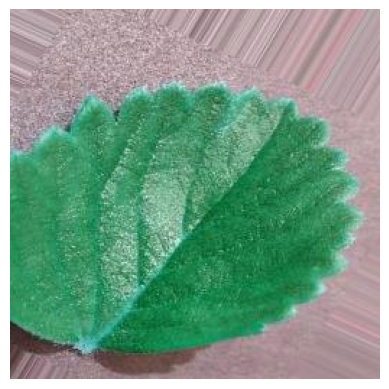

In [20]:
for image_batch, label_batch in train_generator:
    for image in image_batch:
        # print(image)
        plt.imshow(image)
        plt.axis('off')
        break
    break

In [21]:
type(train_generator)

generator

## Modelling -> CNN